In [1]:
import numpy as np
import tensorflow
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
import os
os.listdir("/kaggle/input/coffee/Coffee Unzipped")

['Miner', 'Leaf rust', 'Cerscospora', 'Phoma', 'Healthy']

In [3]:
EPOCHS = 50
INIT_LR = 0.01
BS = 64
default_image_size = tuple((128,128))
image_size = 0
directory_root = '/kaggle/input/coffee'
width = 128
height = 128
depth = 3

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:2500]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True or image_directory.endswith(".jpeg") == True or image_directory.endswith(".JPEG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error --- : {e}")

[INFO] Loading images ...
[INFO] Processing Miner ...
[INFO] Processing Leaf rust ...
[INFO] Processing Cerscospora ...
[INFO] Processing Phoma ...
[INFO] Processing Healthy ...
[INFO] Image loading completed


In [5]:
image_size = len(image_list)
image_size

12500

In [6]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer, open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)

['Cerscospora' 'Healthy' 'Leaf rust' 'Miner' 'Phoma']


In [7]:
np_image_list = np.array(image_list, dtype=np.float16) / 225
print("[INFO] Spliting data to train, test")
X_train, x_test, Y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)
x_val = len(X_train)
x_testval = len(x_test)
y_val = len(Y_train)
y_testval = len(y_test)

x_val, x_testval, y_val, y_testval

[INFO] Spliting data to train, test


(10000, 2500, 10000, 2500)

In [8]:
train_datagen = ImageDataGenerator (rotation_range=45, width_shift_range=0.4, 
                                    height_shift_range=0.3, shear_range=0.4, zoom_range=0.5, 
                                    fill_mode='nearest', horizontal_flip=True,validation_split=0.2)

In [9]:
def Res_Plot_Test_Save(name):
    print("[INFO] Plotting model accuracy and Loss")
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'b', label='Training accurarcy')
    plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
    plt.title('Training and Validation accurarcy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()
    
    print("[INFO] Calculating model accuracy")
    scores = model.evaluate(x_test, y_test)
    print(f"Test Accuracy: {scores[1]*100}")

In [10]:
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical

densemodel = tensorflow.keras.applications.DenseNet121(weights='imagenet', include_top= False, input_shape=(128,128,3))

for layer in densemodel.layers[:149]:
    layer.trainable = False
for layer in densemodel.layers[149:]:
    layer.trainable = True
    
model = tensorflow.keras.models.Sequential()
model.add(densemodel)
model.add(Flatten())
model.add(BatchNormalization()) 
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))
model.summary()

2023-02-15 12:48:35.522078: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-15 12:48:35.638723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-15 12:48:35.639530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-15 12:48:35.641189: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

29097984/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 4, 4, 1024)        7037504   
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16384)             65536     
_________________________________________________________________
dense (Dense)                (None, 128)               2097280   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________

In [11]:
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
print("[INFO] training network...")

[INFO] training network...


In [12]:
history = model.fit(
    train_datagen.flow(X_train, Y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(X_train) // BS,
    epochs= EPOCHS, verbose=1
    )

2023-02-15 12:48:43.998303: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2023-02-15 12:48:54.179511: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


156/156 [==============================] - 63s 299ms/step - loss: 0.1149 - accuracy: 0.9025 - val_loss: 0.9386 - val_accuracy: 0.7208
Epoch 2/50
156/156 [==============================] - 43s 272ms/step - loss: 0.0473 - accuracy: 0.9632 - val_loss: 0.0843 - val_accuracy: 0.9464
Epoch 3/50
156/156 [==============================] - 42s 271ms/step - loss: 0.0437 - accuracy: 0.9663 - val_loss: 0.1220 - val_accuracy: 0.9408
Epoch 4/50
156/156 [==============================] - 42s 270ms/step - loss: 0.0307 - accuracy: 0.9783 - val_loss: 0.0822 - val_accuracy: 0.9708
Epoch 5/50
156/156 [==============================] - 42s 272ms/step - loss: 0.0373 - accuracy: 0.9719 - val_loss: 0.0527 - val_accuracy: 0.9660
Epoch 6/50
156/156 [==============================] - 42s 271ms/step - loss: 0.0254 - accuracy: 0.9800 - val_loss: 0.0765 - val_accuracy: 0.9608
Epoch 7/50
156/156 [==============================] - 45s 287ms/step - loss: 0.0273 - accuracy: 0.9800 - val_loss: 0.0501 - val_accuracy: 0.9

[INFO] Plotting model accuracy and Loss


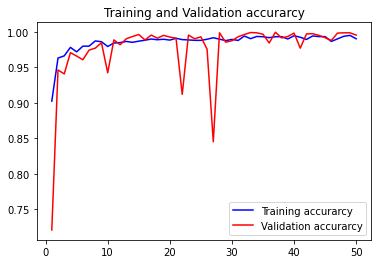

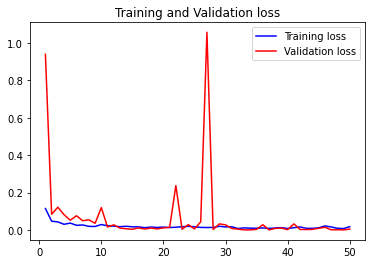

[INFO] Calculating model accuracy
79/79 [==============================] - 2s 29ms/step - loss: 0.0053 - accuracy: 0.9956
Test Accuracy: 99.55999851226807


In [13]:
Res_Plot_Test_Save('densenet121.h5')

In [14]:
model.save("densenet.h5")

In [15]:
import tensorflow as tf

model = tf.keras.models.load_model('densenet.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("densenet.tflite", "wb").write(tflite_model)

2023-02-15 13:44:06.908185: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2023-02-15 13:44:48.639843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-15 13:44:48.640284: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-02-15 13:44:48.641289: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-02-15 13:44:48.642642: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-15 13:44:48.643130: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had ne

36323812